## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:

from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.75]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0831 16:40:09.277275  4836 deprecation_wrapper.py:119] From C:\Users\ELWIN_NB_PS63\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0831 16:40:09.279778  4836 deprecation_wrapper.py:119] From C:\Users\ELWIN_NB_PS63\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0831 16:40:09.282940  4836 deprecation_wrapper.py:119] From C:\Users\ELWIN_NB_PS63\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0831 16:40:09.383642  4836 deprecation_wrapper.py:119] From C:\Users\ELWIN_NB_PS63\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0831 16:40:09.753290  4836 deprecation_wrapper.py:119] From C:\Users\ELWIN_NB_PS63\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0831 16:40:09.768992  4836 deprecation_wrapper.py:119] From C:\Users\ELWIN_NB_PS63\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0831 16:40:09.918552  4836 deprecation.py:323] From C:\Users\ELWIN_NB_PS63\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 4s 78us/step - loss: 1.3625 - acc: 0.5269 - val_loss: 1.5445 - val_acc: 0.4581
Epoch 14/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.3422 - acc: 0.5344 - val_loss: 1.5318 - val_acc: 0.4623
Epoch 15/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.3235 - acc: 0.5412 - val_loss: 1.5252 - val_acc: 0.4654
Epoch 16/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.3063 - acc: 0.5473 - val_loss: 1.5206 - val_acc: 0.4650
Epoch 17/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.2877 - acc: 0.5571 - val_loss: 1.5124 - val_acc: 0.4683
Epoch 18/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.2717 - acc: 0.5614 - val_loss: 1.5145 - val_acc: 0.4676
Epoch 19/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.2538 - acc: 0.5675 - val_loss: 1.5115 - val_acc: 0.4684
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 7s 133us/step - loss: 2.3590 - acc: 0.2356 - val_loss: 2.1381 - val_acc: 0.2907
Epoch 2/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.8627 - acc: 0.3561 - val_loss: 1.8789 - val_acc: 0.3568
Epoch 3/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.7223 - acc: 0.3990 - val_loss: 1.7664 - val_acc: 0.3859
Epoch 4/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.6465 - acc: 0.4238 - val_loss: 1.7060 - val_acc: 0.4040
Epoch 5/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.5915 - acc: 0.4430 - val_loss: 1.6705 - val_acc: 0.4123
Epoch 6/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.5489 - acc: 0.4584 - val_loss: 1.6430 - val_acc: 0.4251
Epoch 7/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.5123 - acc: 0.4710 - val_loss: 1.6173 - val_acc: 0.4271
Epoch 8/25
50000/50000 [===========================

50000/50000 [==============================] - 4s 74us/step - loss: 0.4628 - acc: 0.8594 - val_loss: 1.6668 - val_acc: 0.5020
Epoch 24/25
50000/50000 [==============================] - 4s 80us/step - loss: 0.4377 - acc: 0.8680 - val_loss: 1.7439 - val_acc: 0.4941
Epoch 25/25
50000/50000 [==============================] - 4s 79us/step - loss: 0.4164 - acc: 0.8786 - val_loss: 1.7080 - val_acc: 0.4998

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048   

50000/50000 [==============================] - 5s 91us/step - loss: 1.1350 - acc: 0.6098 - val_loss: 1.4810 - val_acc: 0.4841
Epoch 10/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.1054 - acc: 0.6223 - val_loss: 1.4595 - val_acc: 0.4862
Epoch 11/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.0743 - acc: 0.6348 - val_loss: 1.4727 - val_acc: 0.4824
Epoch 12/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.0440 - acc: 0.6460 - val_loss: 1.4370 - val_acc: 0.4970
Epoch 13/25
50000/50000 [==============================] - 4s 89us/step - loss: 1.0155 - acc: 0.6588 - val_loss: 1.4659 - val_acc: 0.4879
Epoch 14/25
50000/50000 [==============================] - 4s 78us/step - loss: 0.9895 - acc: 0.6676 - val_loss: 1.4225 - val_acc: 0.5066
Epoch 15/25
50000/50000 [==============================] - 4s 84us/step - loss: 0.9633 - acc: 0.6786 - val_loss: 1.5360 - val_acc: 0.4689
Epoch 16/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.8100 - acc: 0.3706 - val_loss: 1.9226 - val_acc: 0.3536
Epoch 2/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.5348 - acc: 0.4552 - val_loss: 5.8159 - val_acc: 0.1287
Epoch 3/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.4319 - acc: 0.4946 - val_loss: 2.1852 - val_acc: 0.2929
Epoch 4/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.3539 - acc: 0.5217 - val_loss: 1.9269 - val_acc: 0.3683
Epoch 5/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.2921 - acc: 0.5447 - val_loss: 2.2916 - val_acc: 0.3092
Epoch 6/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.2441 - acc: 0.5617 - val_loss: 2.1248 - val_acc: 0.3112

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/25
50000/50000 [======================

50000/50000 [==============================] - 4s 82us/step - loss: 0.7948 - acc: 0.7406 - val_loss: 1.6085 - val_acc: 0.4661
Epoch 23/25
50000/50000 [==============================] - 4s 78us/step - loss: 0.7685 - acc: 0.7493 - val_loss: 1.8758 - val_acc: 0.4307
Epoch 24/25
50000/50000 [==============================] - 4s 86us/step - loss: 0.7447 - acc: 0.7570 - val_loss: 1.8406 - val_acc: 0.4336
Epoch 25/25
50000/50000 [==============================] - 4s 75us/step - loss: 0.7224 - acc: 0.7653 - val_loss: 1.7596 - val_acc: 0.4503
Numbers of exp: 10, reduce_factor: 0.75, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch

50000/50000 [==============================] - 4s 85us/step - loss: 1.2807 - acc: 0.5560 - val_loss: 1.5807 - val_acc: 0.4539
Epoch 9/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.2425 - acc: 0.5709 - val_loss: 1.5358 - val_acc: 0.4585
Epoch 10/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.2087 - acc: 0.5833 - val_loss: 1.5564 - val_acc: 0.4546
Epoch 11/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.1771 - acc: 0.5932 - val_loss: 1.5155 - val_acc: 0.4630
Epoch 12/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.1463 - acc: 0.6059 - val_loss: 1.5095 - val_acc: 0.4765
Epoch 13/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.1166 - acc: 0.6182 - val_loss: 1.5073 - val_acc: 0.4835
Epoch 14/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.0886 - acc: 0.6298 - val_loss: 1.5066 - val_acc: 0.4676
Epoch 15/25
50000/50000 [======================

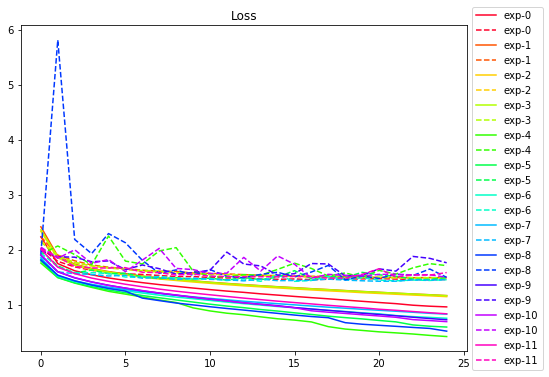

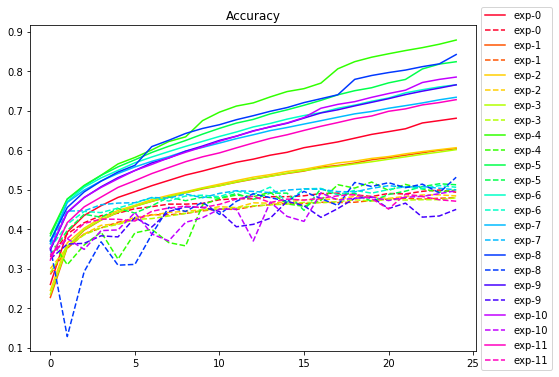

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()